In [0]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
import io
import requests

In [0]:
data_url = 'https://gist.githubusercontent.com/arthurfreitas96/957e4424c9d4c168d9536d2c7bf9409e/raw/89fb378bca3ed6f6279fa095aedd63d3b63b5230/sun_dataset.txt'  #@param {type: "string"}

df = pd.read_csv(io.StringIO(requests.get(data_url).content.decode('utf-8')))
df = df.set_index('d')
summer_time = df.index[df['r'].diff().abs() > 30].tolist()
df[0:summer_time[0]-1] = df[0:summer_time[0]-1] - 60
df[summer_time[1]-1:] = df[summer_time[1]-1:] - 60

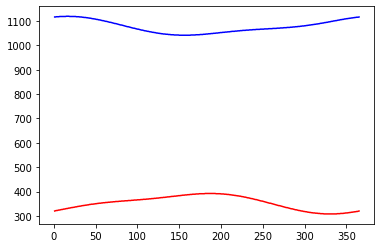

In [4]:
days = df.index.to_numpy()
sunrise = df['r'].to_numpy()
sunset = df['s'].to_numpy()
plt.plot(days,sunrise, "r")
plt.plot(days,sunset, "b")
plt.show()

In [0]:
def fourier(x, *a):
    assert(len(a) % 2 == 0)
    tau = a[0]
    ret = a[1]
    b = a[2:]
    alphas = b[::2]
    phis = b[1::2]
    ns = range(1,len(alphas)+1)
    for alpha,n,phi in zip(alphas, ns, phis):
        ret += alpha * np.sin(n * 2 * np.pi / tau * (x + phi))
    return ret
def get_fourier_c_function(a, name="calc"):
    tau = a[0]
    ret = "int {}(int x)".format(name)+" {\n"
    ret += "  return {}".format(a[1])
    b = a[2:]
    alphas = b[::2]
    phis = b[1::2]
    ns = range(1,len(alphas)+1)
    for alpha,n,phi in zip(alphas, ns, phis):
        w = n * 2 * np.pi / tau 
        k = n * 2 * np.pi / tau * phi
        ret += " {}\n    {} * sin({} * x {} {})".format('+' if alpha > 0 else '-', np.abs(alpha),w,'+' if k > 0 else '-', np.abs(k))
    return ret + ";\n}"

In [13]:
number_of_parameters = 6 #@param {type:"slider", min:4, max:20, step:2}
base_params = [100] * (number_of_parameters-2)
sunrise_ff, _ = curve_fit(fourier, 
                          days,
                          sunrise, 
                          [len(days), np.mean(sunrise)] + base_params)
print("// sunrise_max_error =", np.max(np.abs(sunrise-fourier(days, *sunrise_ff))))
print(get_fourier_c_function(sunrise_ff, "sunrise"))
sunset_ff, _ = curve_fit(fourier, 
                          days,
                          sunset, 
                          [len(days), np.mean(sunset)] + base_params)
print("// sunset_max_error =" , np.max(np.abs(sunset-fourier(days, *sunset_ff))))
print(get_fourier_c_function(sunset_ff, "sunset"))

// sunrise_max_error = 1.9399212031896127
int sunrise(int x) {
  return 352.7057070699647 -
    37.874423615159515 * sin(0.016993372856748738 * x + 1.9702732100174332) -
    9.635480273542653 * sin(0.033986745713497475 * x + 3.5210526762558465);
}
// sunset_max_error = 1.6480860263854993
int sunset(int x) {
  return 1077.7684206276278 +
    34.412579844382826 * sin(0.017048572799752065 * x + 1.5651489841528505) -
    9.938477290115724 * sin(0.03409714559950413 * x + 3.6094381149503607);
}


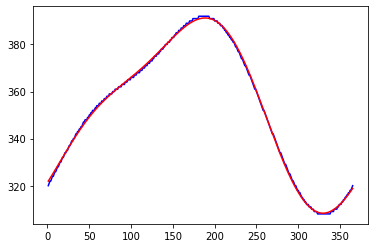

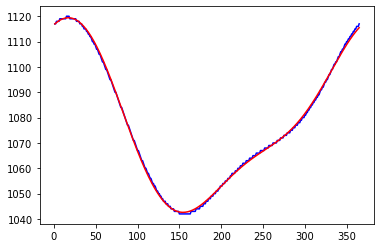

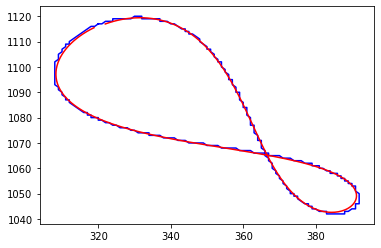

In [14]:
plt.plot(days, sunrise, c='b')
plt.plot(days,fourier(days, *sunrise_ff), c='r')
plt.show()
plt.plot(days, sunset, c='b')
plt.plot(days, fourier(days, *sunset_ff), c='r')
plt.show()
plt.plot(sunrise, sunset, c='b')
plt.plot(fourier(days, *sunrise_ff), fourier(days, *sunset_ff), c='r')
plt.show()